# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=1, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
        
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    x1 = encoder_block(inputs, 16, 2)
    x2 = encoder_block(x1, 32, 2)
    x3 = encoder_block(x2, 64, 2)
    x4 = encoder_block(x3, 128, 2)
    x5 = encoder_block(x4, 256, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    x5_5 = conv2d_batchnorm(x5,256,kernel_size=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x = decoder_block(x5_5, x4, 256)
    x = decoder_block(x, x3, 128)
    x = decoder_block(x, x2, 64)
    x = decoder_block(x, x1, 32)
    x = decoder_block(x, inputs, 16)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.001 # 0.0001 - slow
batch_size = 256 #512/384 => Exhaust resources
num_epochs = 100
steps_per_epoch = 15 #200
validation_steps = 5 #50
workers = 10

Epoch 1/100
14/15 [===========================>..] - ETA: 3s - loss: 1.1983

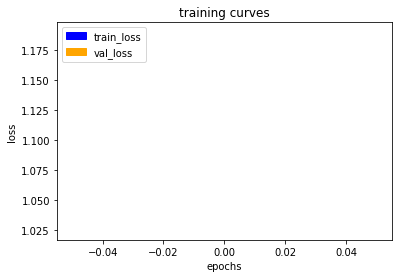

15/15 [==============================] - 61s - loss: 1.1865 - val_loss: 1.0248
Epoch 2/100
14/15 [===========================>..] - ETA: 3s - loss: 0.9394

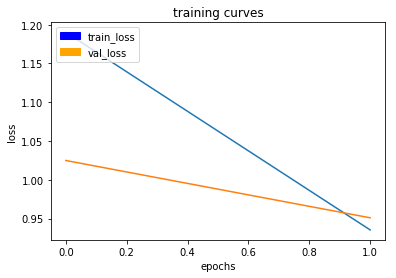

15/15 [==============================] - 57s - loss: 0.9355 - val_loss: 0.9509
Epoch 3/100
14/15 [===========================>..] - ETA: 3s - loss: 0.8320

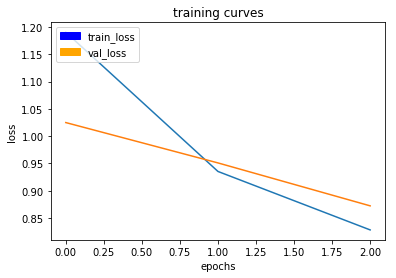

15/15 [==============================] - 56s - loss: 0.8288 - val_loss: 0.8723
Epoch 4/100
14/15 [===========================>..] - ETA: 3s - loss: 0.7409

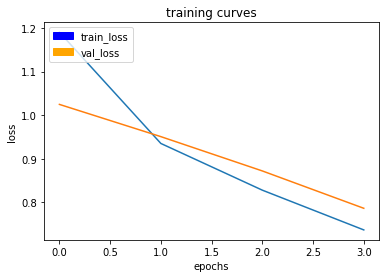

15/15 [==============================] - 57s - loss: 0.7371 - val_loss: 0.7867
Epoch 5/100
14/15 [===========================>..] - ETA: 3s - loss: 0.6520

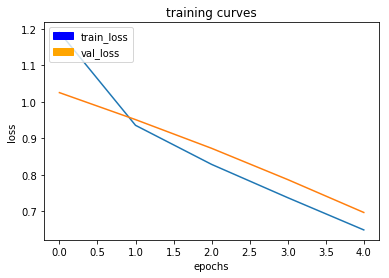

15/15 [==============================] - 56s - loss: 0.6488 - val_loss: 0.6966
Epoch 6/100
14/15 [===========================>..] - ETA: 3s - loss: 0.5689

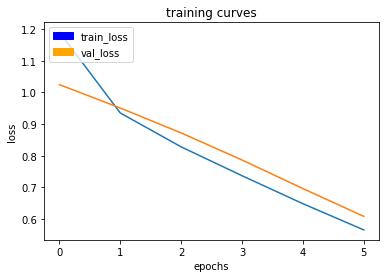

15/15 [==============================] - 58s - loss: 0.5663 - val_loss: 0.6087
Epoch 7/100
14/15 [===========================>..] - ETA: 3s - loss: 0.4911

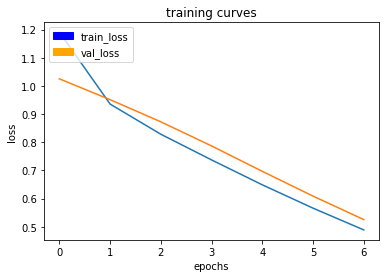

15/15 [==============================] - 56s - loss: 0.4876 - val_loss: 0.5254
Epoch 8/100
14/15 [===========================>..] - ETA: 3s - loss: 0.4124

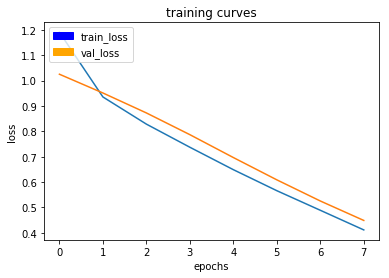

15/15 [==============================] - 57s - loss: 0.4109 - val_loss: 0.4487
Epoch 9/100
14/15 [===========================>..] - ETA: 3s - loss: 0.3525

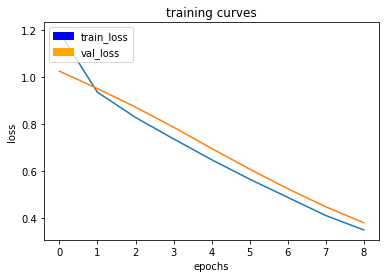

15/15 [==============================] - 58s - loss: 0.3504 - val_loss: 0.3806
Epoch 10/100
14/15 [===========================>..] - ETA: 3s - loss: 0.2931

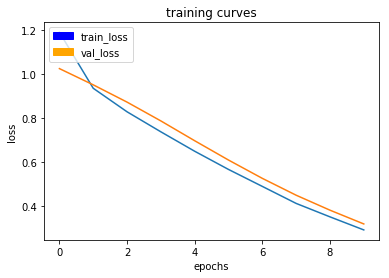

15/15 [==============================] - 56s - loss: 0.2912 - val_loss: 0.3179
Epoch 11/100
14/15 [===========================>..] - ETA: 3s - loss: 0.2469

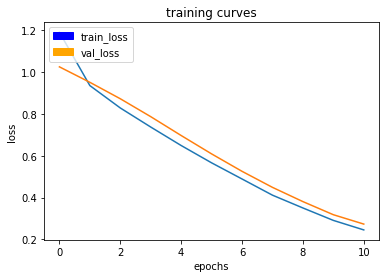

15/15 [==============================] - 57s - loss: 0.2455 - val_loss: 0.2731
Epoch 12/100
14/15 [===========================>..] - ETA: 3s - loss: 0.2097

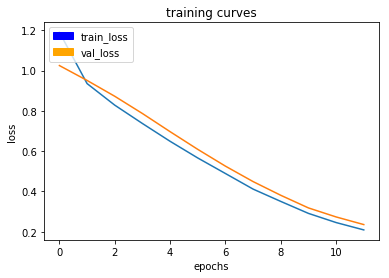

15/15 [==============================] - 56s - loss: 0.2087 - val_loss: 0.2352
Epoch 13/100
14/15 [===========================>..] - ETA: 3s - loss: 0.1779

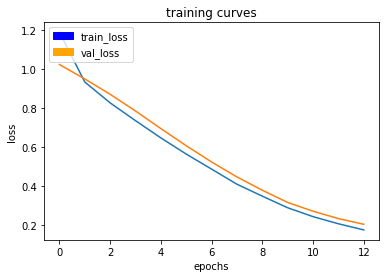

15/15 [==============================] - 57s - loss: 0.1768 - val_loss: 0.2060
Epoch 14/100
14/15 [===========================>..] - ETA: 3s - loss: 0.1563

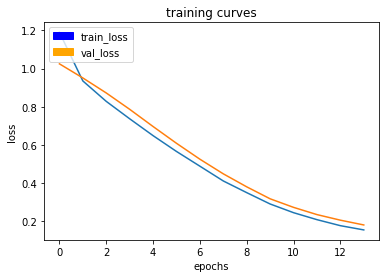

15/15 [==============================] - 57s - loss: 0.1554 - val_loss: 0.1810
Epoch 15/100
14/15 [===========================>..] - ETA: 3s - loss: 0.1342

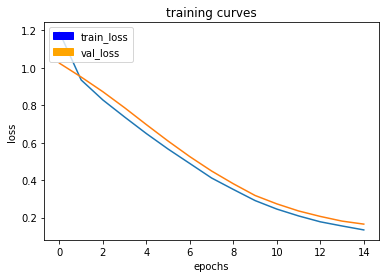

15/15 [==============================] - 57s - loss: 0.1340 - val_loss: 0.1649
Epoch 16/100
14/15 [===========================>..] - ETA: 3s - loss: 0.1175

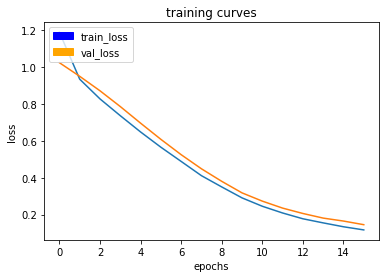

15/15 [==============================] - 57s - loss: 0.1166 - val_loss: 0.1452
Epoch 17/100
14/15 [===========================>..] - ETA: 3s - loss: 0.1035

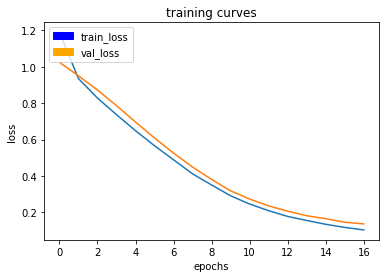

15/15 [==============================] - 56s - loss: 0.1034 - val_loss: 0.1360
Epoch 18/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0924

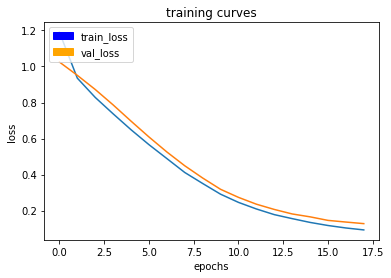

15/15 [==============================] - 57s - loss: 0.0923 - val_loss: 0.1272
Epoch 19/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0846

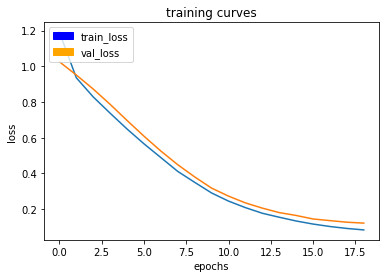

15/15 [==============================] - 56s - loss: 0.0841 - val_loss: 0.1220
Epoch 20/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0765

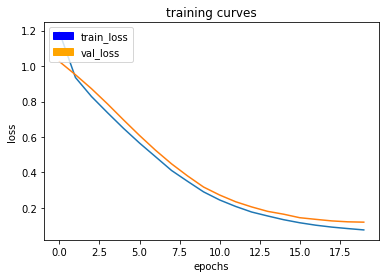

15/15 [==============================] - 57s - loss: 0.0764 - val_loss: 0.1201
Epoch 21/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0681

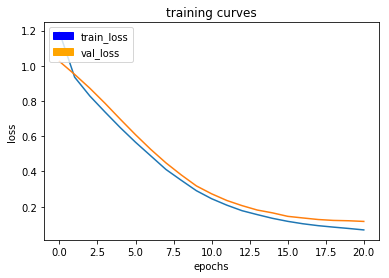

15/15 [==============================] - 56s - loss: 0.0679 - val_loss: 0.1163
Epoch 22/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0641

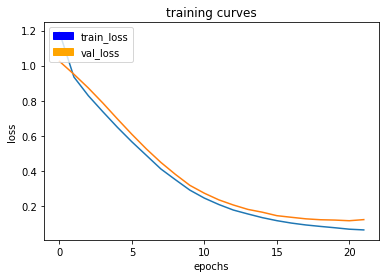

15/15 [==============================] - 57s - loss: 0.0640 - val_loss: 0.1227
Epoch 23/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0586

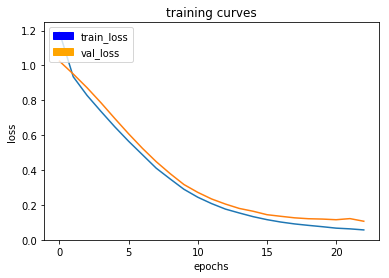

15/15 [==============================] - 57s - loss: 0.0582 - val_loss: 0.1076
Epoch 24/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0553

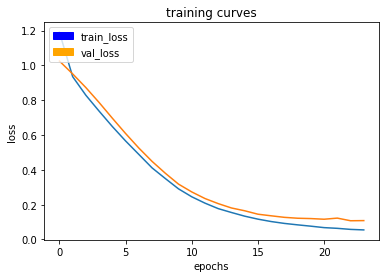

15/15 [==============================] - 56s - loss: 0.0552 - val_loss: 0.1084
Epoch 25/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0514

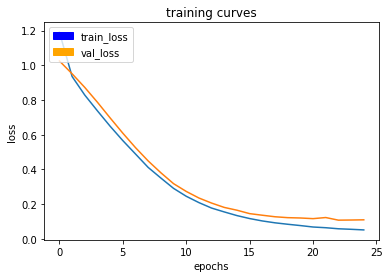

15/15 [==============================] - 57s - loss: 0.0514 - val_loss: 0.1096
Epoch 26/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0476

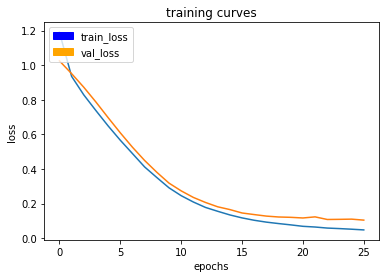

15/15 [==============================] - 56s - loss: 0.0474 - val_loss: 0.1039
Epoch 27/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0459

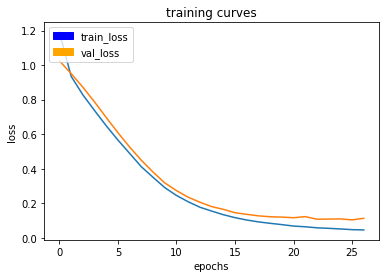

15/15 [==============================] - 57s - loss: 0.0457 - val_loss: 0.1129
Epoch 28/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0424

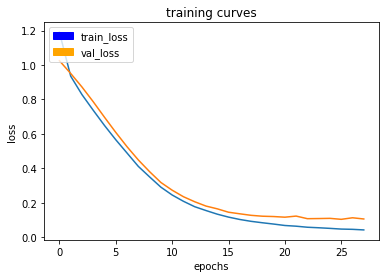

15/15 [==============================] - 58s - loss: 0.0425 - val_loss: 0.1060
Epoch 29/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0401

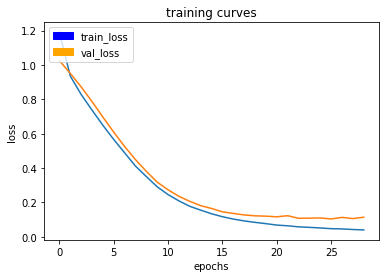

15/15 [==============================] - 57s - loss: 0.0400 - val_loss: 0.1139
Epoch 30/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0377

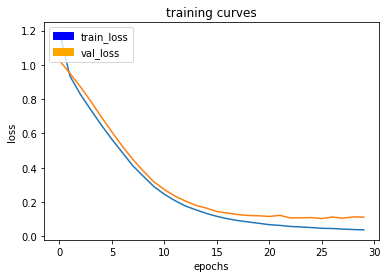

15/15 [==============================] - 56s - loss: 0.0377 - val_loss: 0.1122
Epoch 31/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0355

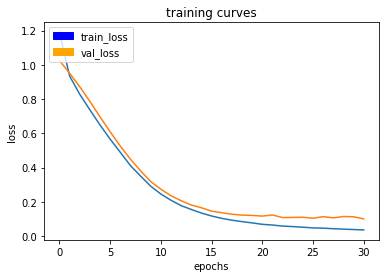

15/15 [==============================] - 57s - loss: 0.0354 - val_loss: 0.0998
Epoch 32/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0343

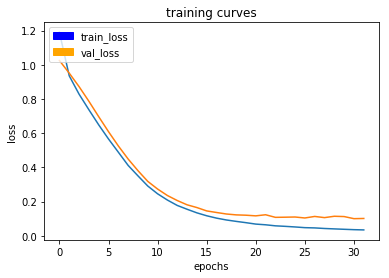

15/15 [==============================] - 57s - loss: 0.0342 - val_loss: 0.1010
Epoch 33/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0324

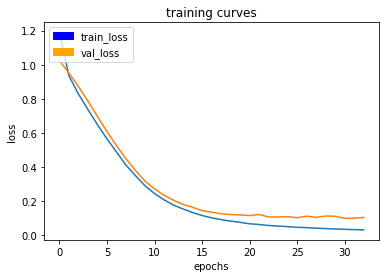

15/15 [==============================] - 55s - loss: 0.0323 - val_loss: 0.1048
Epoch 34/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0316

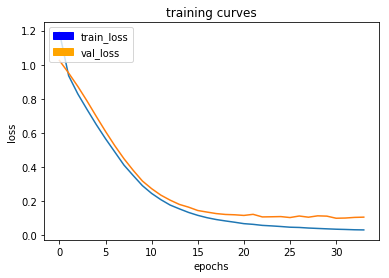

15/15 [==============================] - 57s - loss: 0.0314 - val_loss: 0.1062
Epoch 35/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0310

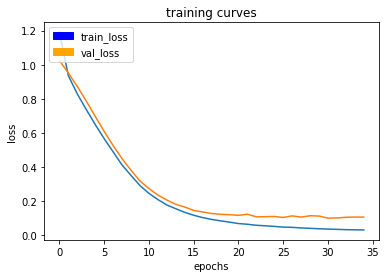

15/15 [==============================] - 56s - loss: 0.0309 - val_loss: 0.1058
Epoch 36/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0289

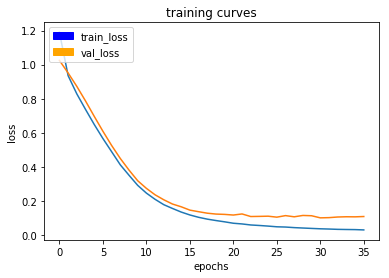

15/15 [==============================] - 58s - loss: 0.0289 - val_loss: 0.1076
Epoch 37/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0286

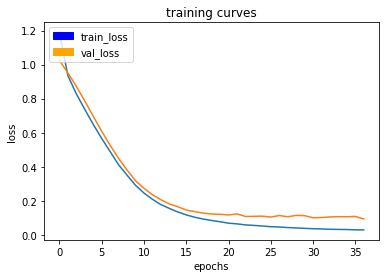

15/15 [==============================] - 56s - loss: 0.0285 - val_loss: 0.0926
Epoch 38/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0273

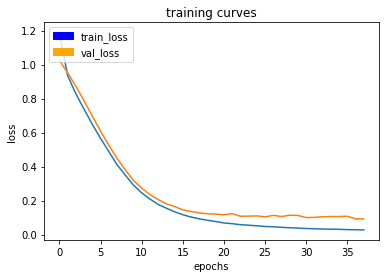

15/15 [==============================] - 57s - loss: 0.0273 - val_loss: 0.0919
Epoch 39/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0264

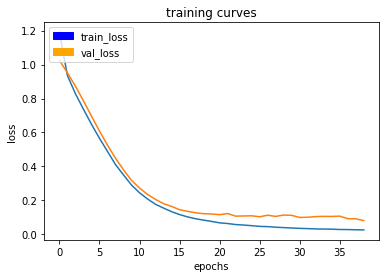

15/15 [==============================] - 57s - loss: 0.0264 - val_loss: 0.0814
Epoch 40/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0258

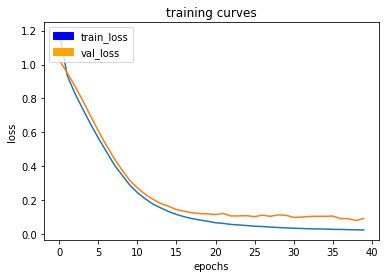

15/15 [==============================] - 56s - loss: 0.0257 - val_loss: 0.0930
Epoch 41/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0247

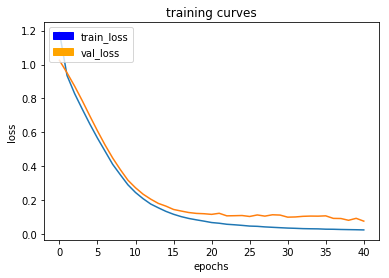

15/15 [==============================] - 57s - loss: 0.0246 - val_loss: 0.0763
Epoch 42/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0245

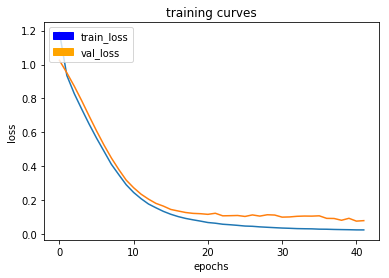

15/15 [==============================] - 56s - loss: 0.0244 - val_loss: 0.0792
Epoch 43/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0232

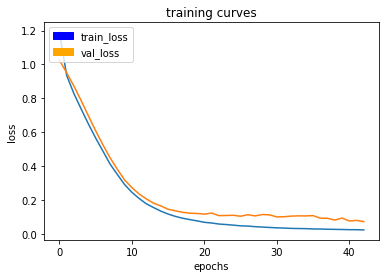

15/15 [==============================] - 59s - loss: 0.0232 - val_loss: 0.0726
Epoch 44/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0231

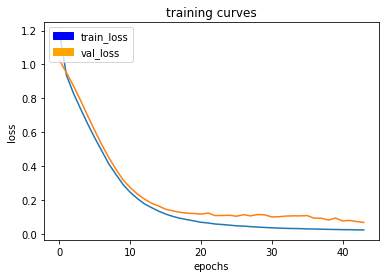

15/15 [==============================] - 57s - loss: 0.0231 - val_loss: 0.0673
Epoch 45/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0226

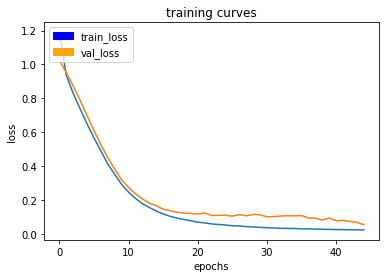

15/15 [==============================] - 57s - loss: 0.0226 - val_loss: 0.0535
Epoch 46/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0216

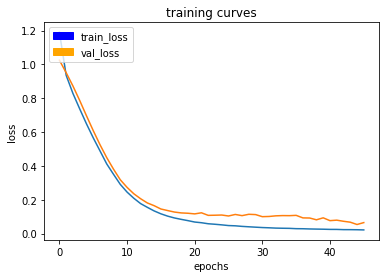

15/15 [==============================] - 57s - loss: 0.0215 - val_loss: 0.0648
Epoch 47/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0209

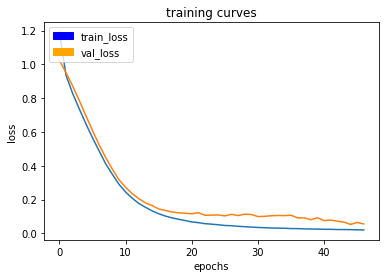

15/15 [==============================] - 56s - loss: 0.0209 - val_loss: 0.0564
Epoch 48/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0207

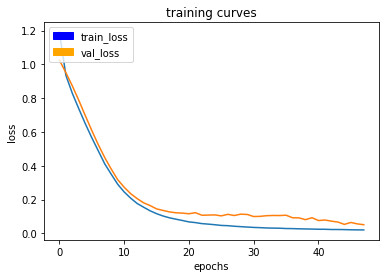

15/15 [==============================] - 57s - loss: 0.0206 - val_loss: 0.0515
Epoch 49/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0201

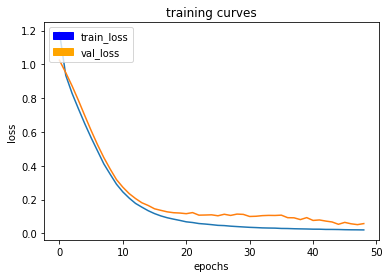

15/15 [==============================] - 56s - loss: 0.0202 - val_loss: 0.0577
Epoch 50/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0197

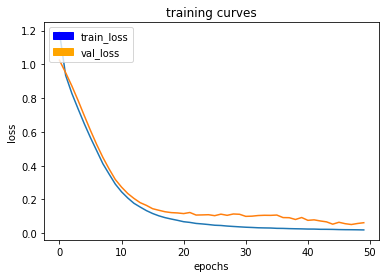

15/15 [==============================] - 57s - loss: 0.0196 - val_loss: 0.0622
Epoch 51/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0195

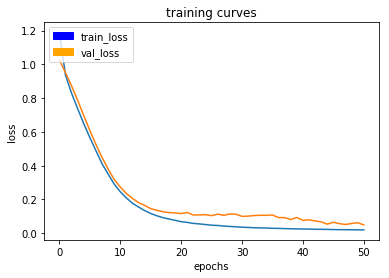

15/15 [==============================] - 56s - loss: 0.0195 - val_loss: 0.0492
Epoch 52/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0189

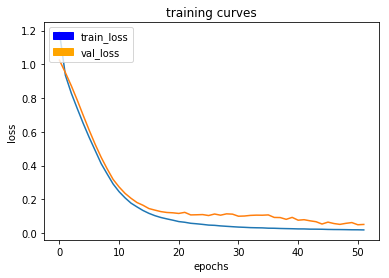

15/15 [==============================] - 57s - loss: 0.0187 - val_loss: 0.0511
Epoch 53/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0188

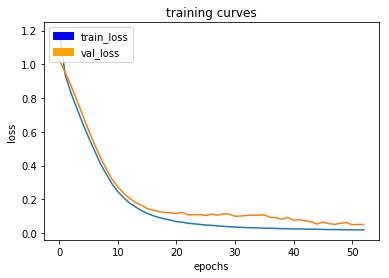

15/15 [==============================] - 57s - loss: 0.0188 - val_loss: 0.0508
Epoch 54/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0180

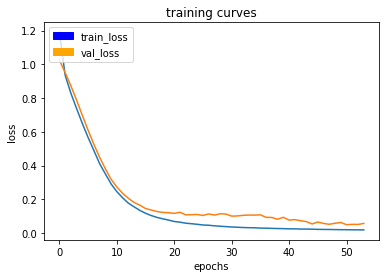

15/15 [==============================] - 56s - loss: 0.0181 - val_loss: 0.0566
Epoch 55/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0176

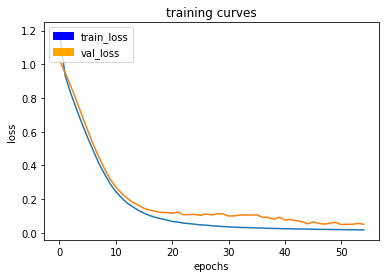

15/15 [==============================] - 58s - loss: 0.0176 - val_loss: 0.0509
Epoch 56/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0176

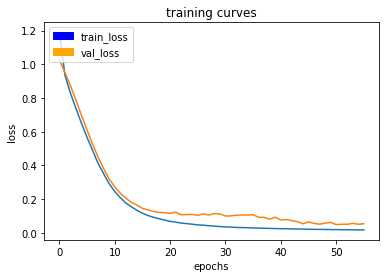

15/15 [==============================] - 56s - loss: 0.0176 - val_loss: 0.0547
Epoch 57/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0171

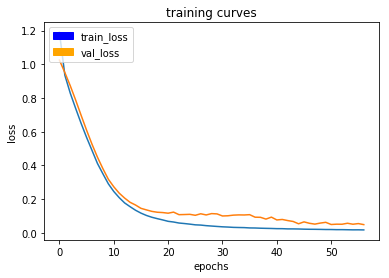

15/15 [==============================] - 59s - loss: 0.0171 - val_loss: 0.0486
Epoch 58/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0171

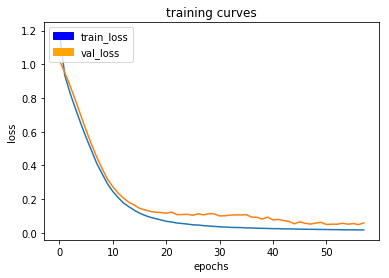

15/15 [==============================] - 56s - loss: 0.0171 - val_loss: 0.0585
Epoch 59/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0168

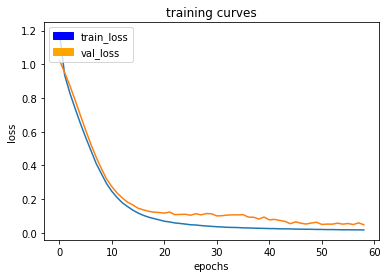

15/15 [==============================] - 57s - loss: 0.0167 - val_loss: 0.0476
Epoch 60/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0165

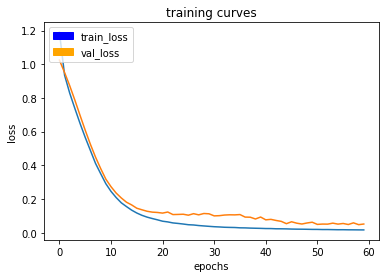

15/15 [==============================] - 55s - loss: 0.0165 - val_loss: 0.0514
Epoch 61/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0158

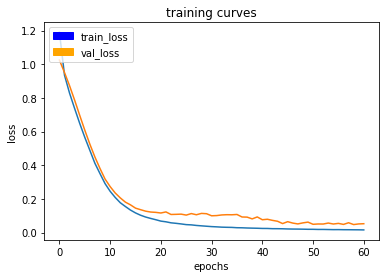

15/15 [==============================] - 57s - loss: 0.0158 - val_loss: 0.0527
Epoch 62/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0160

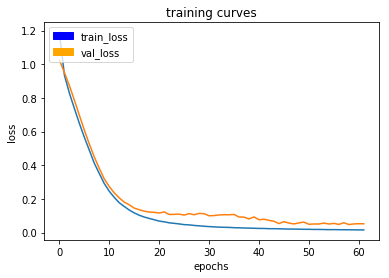

15/15 [==============================] - 58s - loss: 0.0160 - val_loss: 0.0523
Epoch 63/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0158

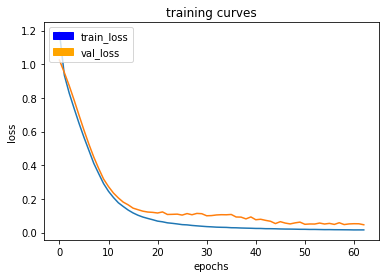

15/15 [==============================] - 56s - loss: 0.0159 - val_loss: 0.0465
Epoch 64/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0156

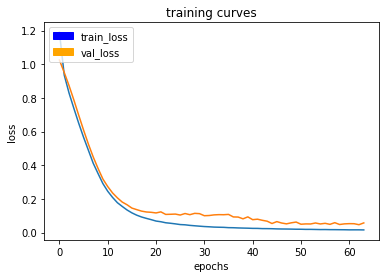

15/15 [==============================] - 57s - loss: 0.0155 - val_loss: 0.0571
Epoch 65/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0157

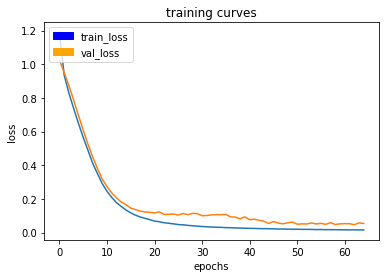

15/15 [==============================] - 56s - loss: 0.0156 - val_loss: 0.0536
Epoch 66/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0150

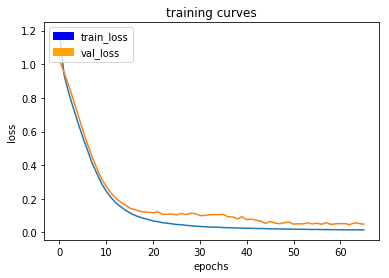

15/15 [==============================] - 57s - loss: 0.0150 - val_loss: 0.0488
Epoch 67/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0155

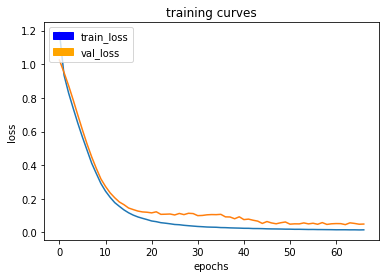

15/15 [==============================] - 56s - loss: 0.0155 - val_loss: 0.0499
Epoch 68/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0153

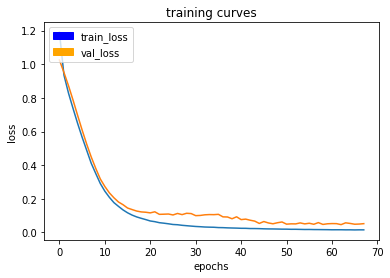

15/15 [==============================] - 58s - loss: 0.0153 - val_loss: 0.0522
Epoch 69/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0151

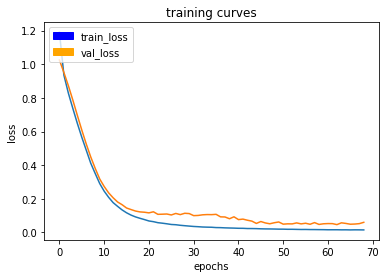

15/15 [==============================] - 57s - loss: 0.0150 - val_loss: 0.0601
Epoch 70/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0146

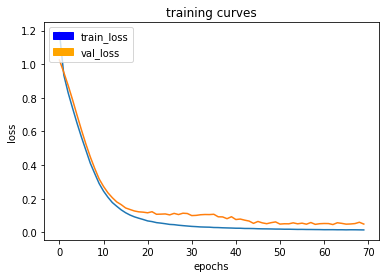

15/15 [==============================] - 56s - loss: 0.0146 - val_loss: 0.0493
Epoch 71/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0143

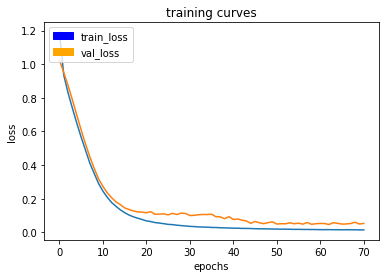

15/15 [==============================] - 57s - loss: 0.0143 - val_loss: 0.0531
Epoch 72/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0138

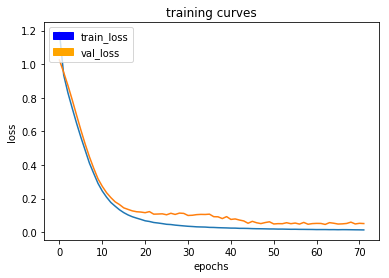

15/15 [==============================] - 57s - loss: 0.0138 - val_loss: 0.0517
Epoch 73/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0135

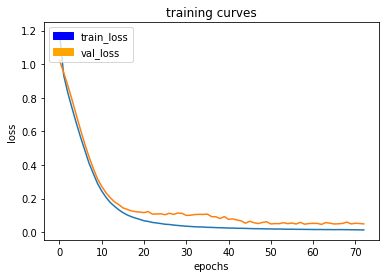

15/15 [==============================] - 58s - loss: 0.0135 - val_loss: 0.0493
Epoch 74/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0141

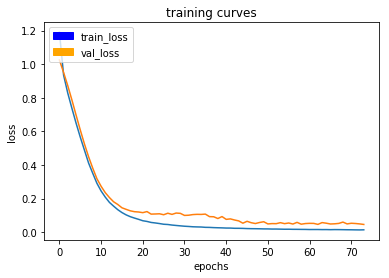

15/15 [==============================] - 56s - loss: 0.0141 - val_loss: 0.0461
Epoch 75/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0136

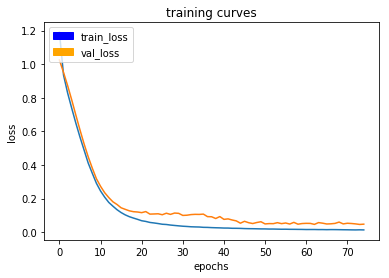

15/15 [==============================] - 58s - loss: 0.0135 - val_loss: 0.0477
Epoch 76/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0136

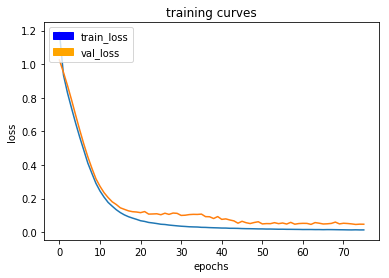

15/15 [==============================] - 57s - loss: 0.0135 - val_loss: 0.0474
Epoch 77/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0134

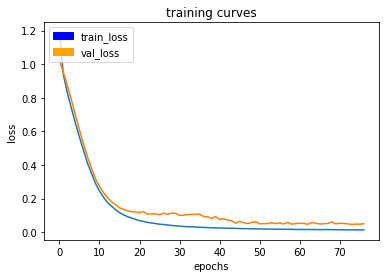

15/15 [==============================] - 56s - loss: 0.0134 - val_loss: 0.0502
Epoch 78/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0134

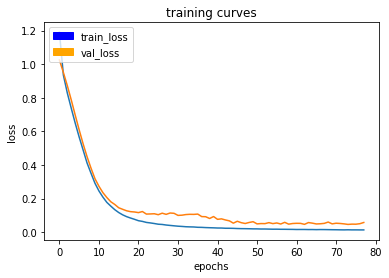

15/15 [==============================] - 57s - loss: 0.0133 - val_loss: 0.0576
Epoch 79/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0129

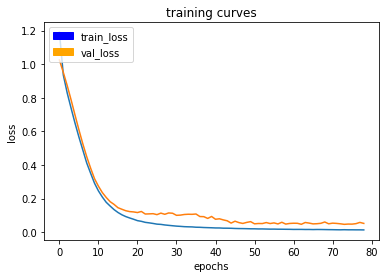

15/15 [==============================] - 56s - loss: 0.0129 - val_loss: 0.0517
Epoch 80/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0126

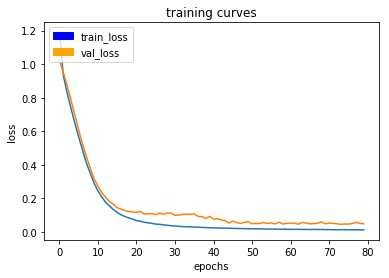

15/15 [==============================] - 57s - loss: 0.0125 - val_loss: 0.0491
Epoch 81/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0125

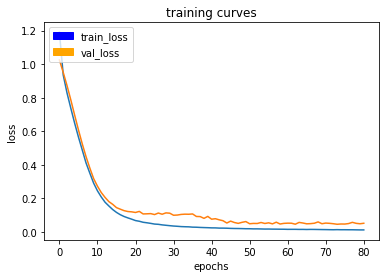

15/15 [==============================] - 56s - loss: 0.0125 - val_loss: 0.0521
Epoch 82/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0126

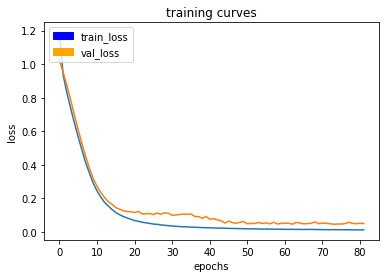

15/15 [==============================] - 57s - loss: 0.0125 - val_loss: 0.0503
Epoch 83/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0125

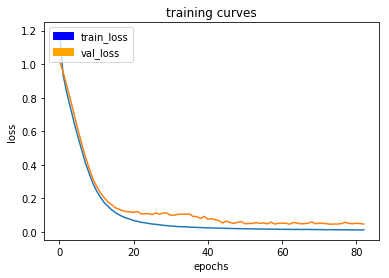

15/15 [==============================] - 57s - loss: 0.0124 - val_loss: 0.0475
Epoch 84/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0121

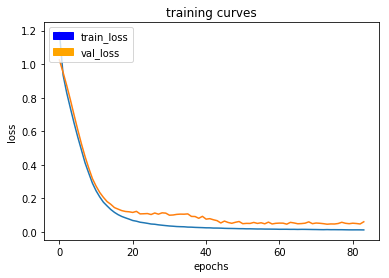

15/15 [==============================] - 56s - loss: 0.0121 - val_loss: 0.0607
Epoch 85/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0122

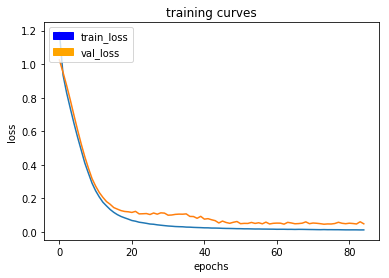

15/15 [==============================] - 57s - loss: 0.0122 - val_loss: 0.0484
Epoch 86/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0120

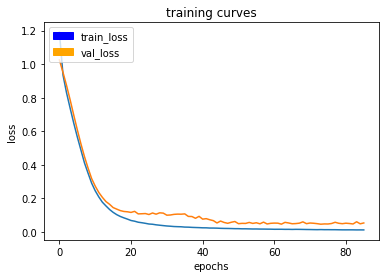

15/15 [==============================] - 57s - loss: 0.0120 - val_loss: 0.0535
Epoch 87/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0121

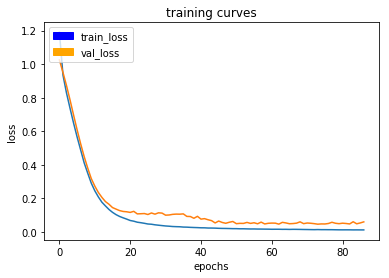

15/15 [==============================] - 57s - loss: 0.0121 - val_loss: 0.0600
Epoch 88/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0118

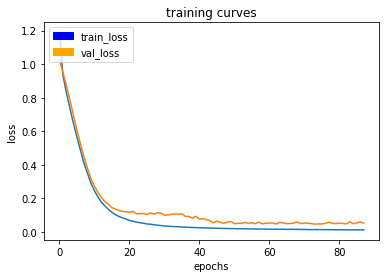

15/15 [==============================] - 55s - loss: 0.0118 - val_loss: 0.0526
Epoch 89/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0117

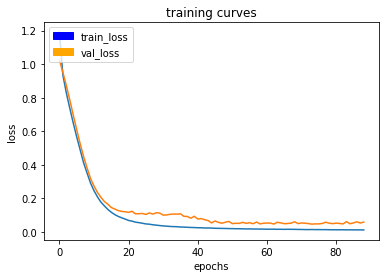

15/15 [==============================] - 58s - loss: 0.0116 - val_loss: 0.0586
Epoch 90/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0117

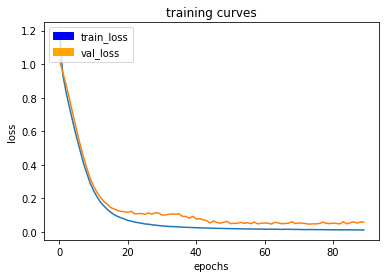

15/15 [==============================] - 56s - loss: 0.0118 - val_loss: 0.0582
Epoch 91/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0120

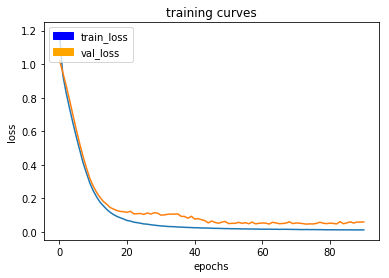

15/15 [==============================] - 57s - loss: 0.0119 - val_loss: 0.0597
Epoch 92/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0115

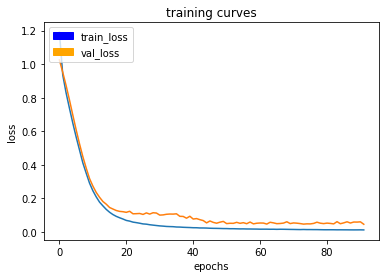

15/15 [==============================] - 57s - loss: 0.0115 - val_loss: 0.0452
Epoch 93/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0115

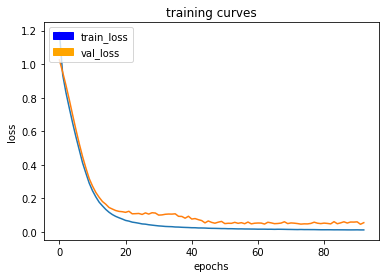

15/15 [==============================] - 55s - loss: 0.0116 - val_loss: 0.0547
Epoch 94/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0113

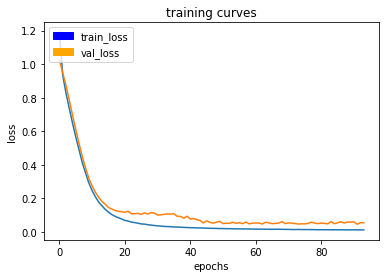

15/15 [==============================] - 57s - loss: 0.0114 - val_loss: 0.0538
Epoch 95/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0113

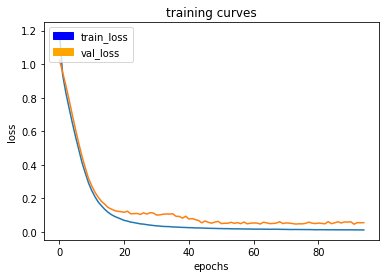

15/15 [==============================] - 56s - loss: 0.0113 - val_loss: 0.0546
Epoch 96/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0111

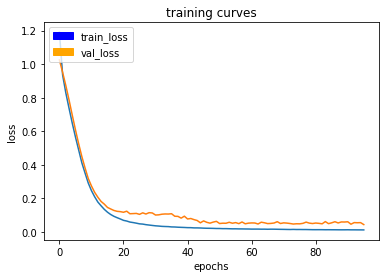

15/15 [==============================] - 58s - loss: 0.0111 - val_loss: 0.0429
Epoch 97/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0110

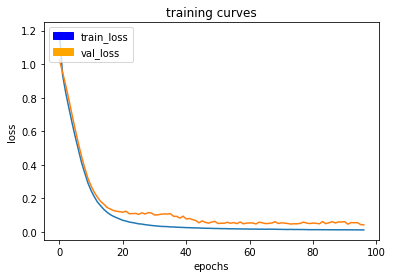

15/15 [==============================] - 56s - loss: 0.0111 - val_loss: 0.0409
Epoch 98/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0110

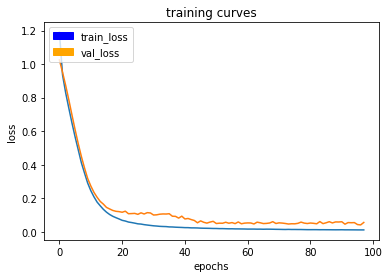

15/15 [==============================] - 58s - loss: 0.0110 - val_loss: 0.0554
Epoch 99/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0110

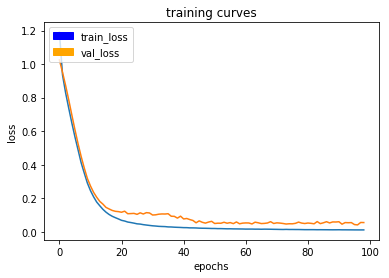

15/15 [==============================] - 58s - loss: 0.0110 - val_loss: 0.0549
Epoch 100/100
14/15 [===========================>..] - ETA: 3s - loss: 0.0110

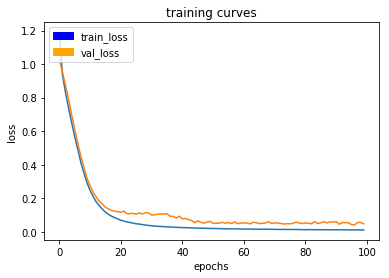

15/15 [==============================] - 57s - loss: 0.0109 - val_loss: 0.0470


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

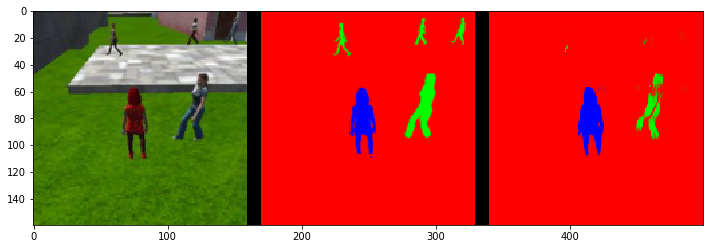

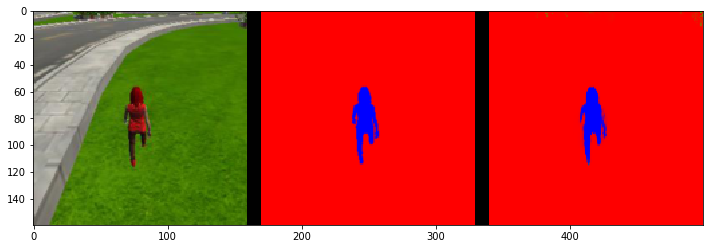

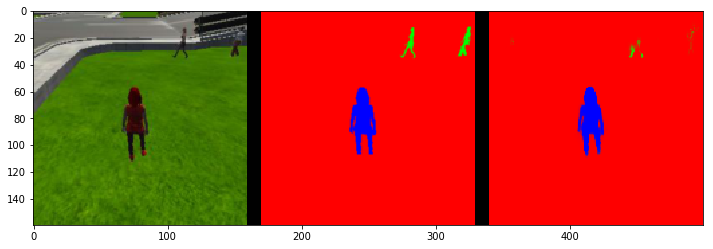

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

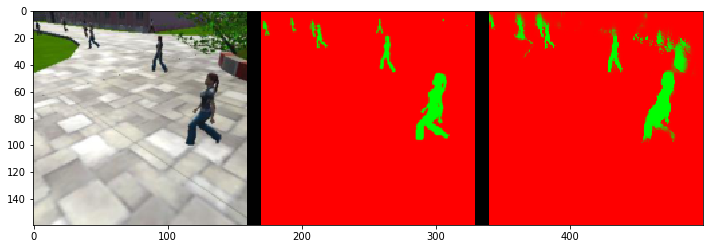

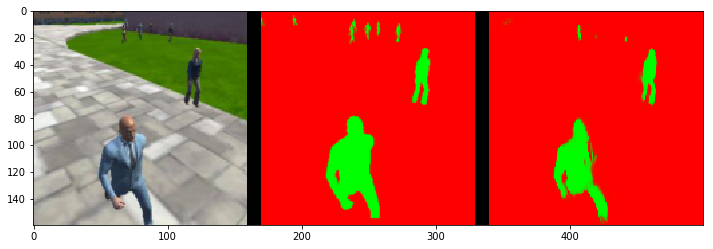

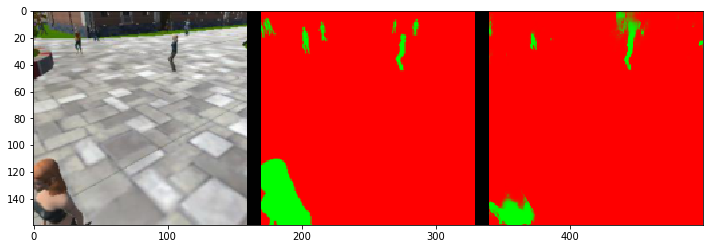

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

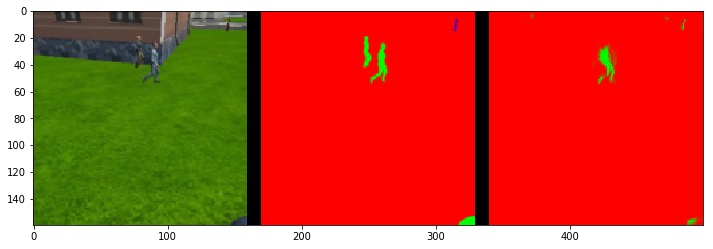

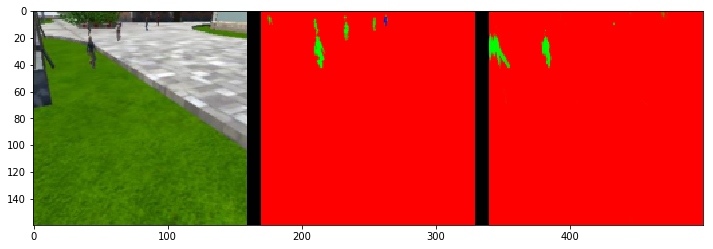

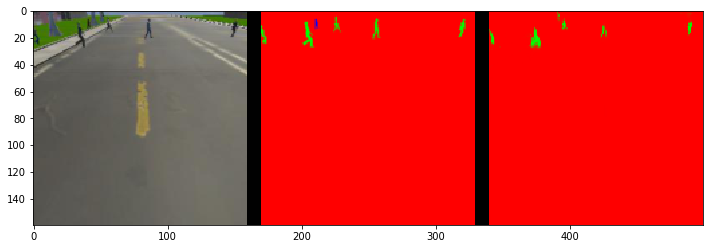

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9926716632398312
average intersection over union for other people is 0.20508508437801998
average intersection over union for the hero is 0.8992309058836112
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9759329773071639
average intersection over union for other people is 0.5069319561910606
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 85, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9925801877073422
average intersection over union for other people is 0.2505547516864117
average intersection over union for the hero is 0.028113488043634245
number true positives: 46, number false positives: 1, number false negatives: 255


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6317494600431965


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.463672196964


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.292924660069
